# ● Libraries

In [1]:
import tqdm
import time
import numpy as np
import cv2
from sklearn.metrics import (roc_curve, auc, accuracy_score, f1_score, precision_score, 
                             recall_score, classification_report, confusion_matrix)
from skimage.feature import hog
import seaborn as sn
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, StratifiedKFold
from dataio import *
from preprocess import *
from colorfeatures import *
from classify import *

In [11]:
# Save/Load Prior Session Variables
import dill
dill.dump_session('train-val_env.db')
#dill.load_session('train-val_env.db')

# ● Dataset

In [3]:
train_data = sortData('../data/train')           # Load Training Set

Number of B0 Images: 13108
Number of M0 Images: 13108


In [4]:
val_data   = sortData('../data/val')             # Load Validation Set

Number of B0 Images: 1639
Number of M0 Images: 1639


In [5]:
# Pass Target Image
index1  = findScan(train_data,'b_trainImage115','id')
sample1 = (plt.imread(train_data[index1]['image'])*255).astype(np.uint8)
index2  = findScan(train_data,'b_trainImage111','id')
sample2 = (plt.imread(train_data[index2]['image'])*255).astype(np.uint8)
index3  = findScan(train_data,'b_trainImage140','id')
sample3 = (plt.imread(train_data[index3]['image'])*255).astype(np.uint8)

# ● Preprocessing

## Color Constancy (Gray World, White-Balance, Gray-Edge, Max-RGB)

(<matplotlib.axes._subplots.AxesSubplot at 0x12790cdada0>,
 <matplotlib.image.AxesImage at 0x12790d4cb38>)

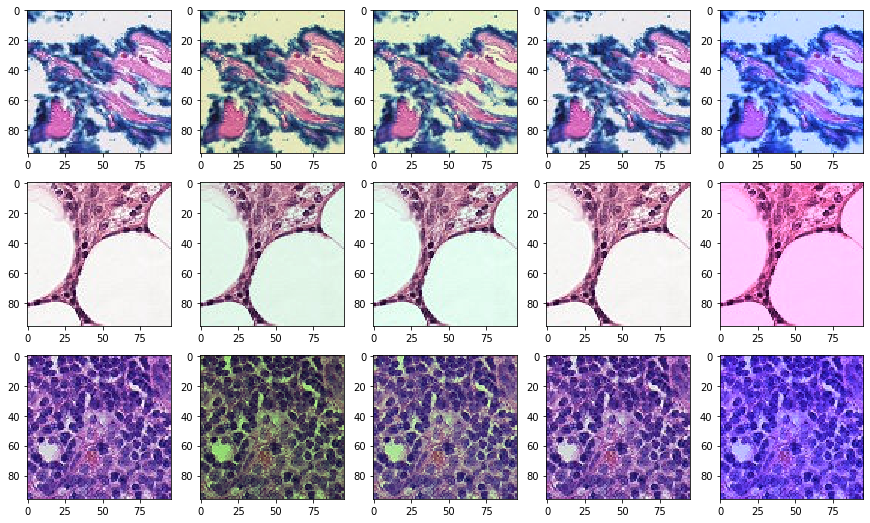

In [6]:
# Color-Constant Transformation
cc1,_ = color_constant(sample1)
cc2,_ = color_constant(sample2)
cc3,_ = color_constant(sample3)

# White-Balance Transformation
wb11 = white_balance(sample1)
wb22 = white_balance(sample2)
wb33 = white_balance(sample3)

# Max-RGB Normalization
mx1 = (correct_image(sample1, grey_edge(sample1, njet=0, mink_norm=-1, sigma=0))*255).astype(np.uint8)
mx2 = (correct_image(sample2, grey_edge(sample2, njet=0, mink_norm=-1, sigma=0))*255).astype(np.uint8)
mx3 = (correct_image(sample3, grey_edge(sample3, njet=0, mink_norm=-1, sigma=0))*255).astype(np.uint8)

# Gray-Edge Color Constancy
ge1 = correct_image(sample1, grey_edge(sample1, njet=1, mink_norm=5, sigma=2))
ge2 = correct_image(sample2, grey_edge(sample2, njet=1, mink_norm=5, sigma=2))
ge3 = correct_image(sample3, grey_edge(sample3, njet=1, mink_norm=5, sigma=2))


plt.figure(figsize=[15,9])
plt.subplot(351),    plt.imshow(sample1)
plt.subplot(352),    plt.imshow(cc1)
plt.subplot(353),    plt.imshow(wb11)
plt.subplot(354),    plt.imshow(mx1)
plt.subplot(355),    plt.imshow(ge1)
plt.subplot(356),    plt.imshow(sample2)
plt.subplot(357),    plt.imshow(cc2)
plt.subplot(358),    plt.imshow(wb22)
plt.subplot(359),    plt.imshow(mx2)
plt.subplot(3,5,10), plt.imshow(ge2)
plt.subplot(3,5,11), plt.imshow(sample3)
plt.subplot(3,5,12), plt.imshow(cc3)
plt.subplot(3,5,13), plt.imshow(wb33)
plt.subplot(3,5,14), plt.imshow(mx3)
plt.subplot(3,5,15), plt.imshow(ge3)

## CLAHE Equalization and PDE-ROF Denoising

(<matplotlib.axes._subplots.AxesSubplot at 0x12790ed3828>,
 <matplotlib.image.AxesImage at 0x12790f435c0>)

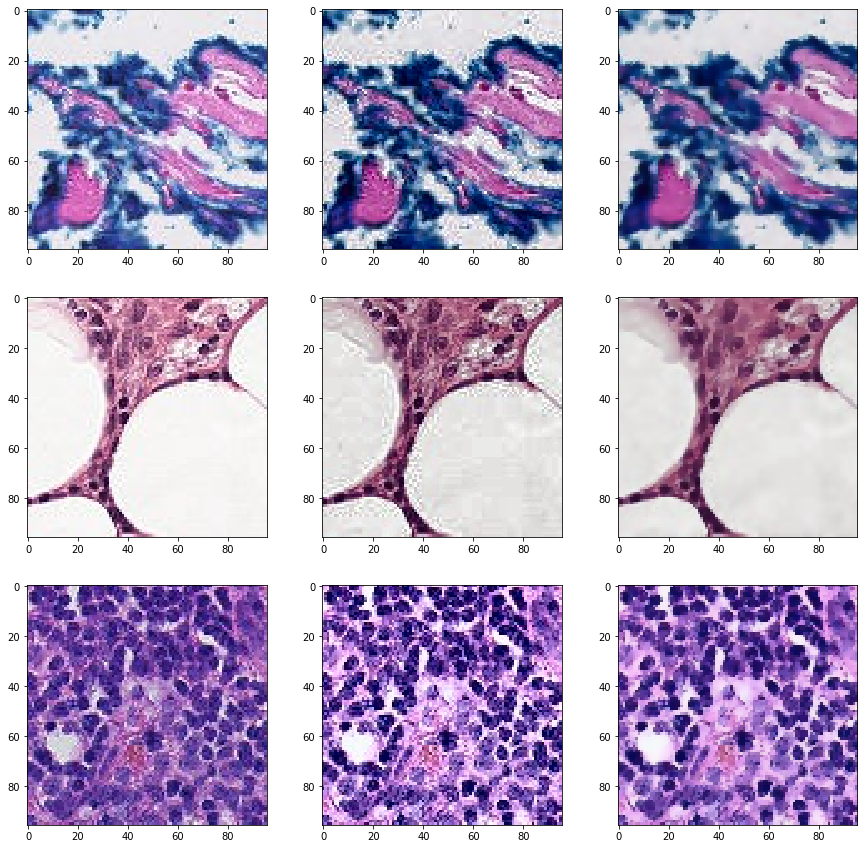

In [7]:
# CLAHE Preprocessing
cl1   = clahe_LAB(sample1)
cl2   = clahe_LAB(sample2)
cl3   = clahe_LAB(sample3)

# PDE-ROF Denoising
denoi1   = denoise_RGB(cl1, weight=10)
denoi2   = denoise_RGB(cl2, weight=10)
denoi3   = denoise_RGB(cl3, weight=10)

plt.figure(figsize=[15,15])
plt.subplot(331),    plt.imshow(sample1)
plt.subplot(332),    plt.imshow(cl1)
plt.subplot(333),    plt.imshow(denoi1)
plt.subplot(334),    plt.imshow(sample2)
plt.subplot(335),    plt.imshow(cl2)
plt.subplot(336),    plt.imshow(denoi2)
plt.subplot(337),    plt.imshow(sample3)
plt.subplot(338),    plt.imshow(cl3)
plt.subplot(339),    plt.imshow(denoi3)

# ● Feature Extraction

In [8]:
def extract_features(image,mask=None):    
    # Color Spaces: I/O -------------------------------------------------------------------------------------------------------------------------------------
    img_RGB               = image
    img_GL                = cv2.cvtColor(img_RGB, cv2.COLOR_RGB2GRAY)
    img_HSV               = cv2.cvtColor(img_RGB, cv2.COLOR_RGB2HSV)
    img_LAB               = cv2.cvtColor(img_RGB, cv2.COLOR_RGB2Lab)
    img_YCrCb             = cv2.cvtColor(img_RGB, cv2.COLOR_RGB2YCrCb)
    img_luv               = cv2.cvtColor(img_RGB, cv2.COLOR_RGB2Luv)
    #---------------------------------------------------------------------------------------------------------------------------------------------------------

    
    # Color Moments ------------------------------------------------------------------------------------------------------------------------------------------
    mean_R, std_R, skew_R, kurt_R, mean_G,  std_G,  skew_G,  kurt_G,  mean_B,  std_B,  skew_B,  kurt_B   = color_moments(img_RGB,     channel=3)
    mean_H, std_H, skew_H, kurt_H, mean_S,  std_S,  skew_S,  kurt_S,  mean_V,  std_V,  skew_V,  kurt_V   = color_moments(img_HSV,     channel=3)
    mean_L, std_L, skew_L, kurt_L, mean_A,  std_A,  skew_A,  kurt_A,  mean_b,  std_b,  skew_b,  kurt_b   = color_moments(img_LAB,     channel=3)
    mean_Y, std_Y, skew_Y, kurt_Y, mean_Cr, std_Cr, skew_Cr, kurt_Cr, mean_Cb, std_Cb, skew_Cb, kurt_Cb  = color_moments(img_YCrCb,   channel=3)
    mean_l, std_l, skew_l, kurt_l, mean_u,  std_u,  skew_u,  kurt_u,  mean_v,  std_v,  skew_v,  kurt_v   = color_moments(img_luv,     channel=3)
    #---------------------------------------------------------------------------------------------------------------------------------------------------------
    
    # Graylevel Co-Occurrence Matrix ----------------------
    GLCM_RGB   = GLCM(img_RGB,   channel=3)
    GLCM_HSV   = GLCM(img_HSV,   channel=3)    
    GLCM_LAB   = GLCM(img_LAB,   channel=3)
    #------------------------------------------------------
    
    # Local Binary Patterns --------------------------------------------------------------------
    lbp_R, lbp_G, lbp_B    = LBP(img_RGB,   channel=3)
    lbp_H, lbp_S, lbp_V    = LBP(img_HSV,   channel=3)
    lbp_Y, lbp_Cr, lbp_Cb  = LBP(img_YCrCb, channel=3) 
    lbp_GL                 = LBP(img_GL,    channel=1) 
    LBP_CGLF  = np.concatenate((lbp_R,lbp_G,lbp_B,lbp_H,lbp_S,lbp_V,lbp_Y,lbp_Cr,lbp_Cb,lbp_GL),axis=0)
    #-------------------------------------------------------------------------------------------
    
    # Smoothness, Uniformity, Entropy -----------------------------
    smoothness_GL, uniformity_GL, entropy_GL = entropyplus(img_GL)
    #--------------------------------------------------------------   
    
    # Graph Features ---------------------------------------------------------------------------------------------
    voronoi     = voronoi_features(img_GL)
    delaunay    = delaunay_features(img_GL)
    #--------------------------------------------------------------------------------------------------------------
    
    # Gabor Filter Features ---------------------------------------------------------------------------------------
    gabor_filters    = []
    gabor_energy     = []
    kernel_size      = 8
    thetas           = [0, np.pi/8, np.pi/4, 3*np.pi/8, np.pi/2, 5*np.pi/8, 3*np.pi/4, 7*np.pi/8, np.pi]
    for theta in thetas:
        kern = cv2.getGaborKernel((kernel_size,kernel_size), 3.25, theta, 9.0, 1.0, 1.0, ktype=cv2.CV_32F)
        kern /= 1.5*kern.sum()
        gabor_filters.append(kern) 
    for kern in gabor_filters:
        fimg         = cv2.filter2D(img_GL, cv2.CV_8UC3, kern)
        GLCM_gabor   = greycomatrix(fimg,  [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], levels=2**8)
        gabor_energy.append(greycoprops(GLCM_gabor,'energy').mean())
    #--------------------------------------------------------------------------------------------------------------
    
    
    features = [ mean_R, std_R, skew_R, mean_G,  std_G,  skew_G,  mean_B,  std_B,  skew_B,   
                 mean_H, std_H, skew_H, mean_S,  std_S,  skew_S,  mean_V,  std_V,  skew_V,   
                 mean_L, std_L, skew_L, mean_A,  std_A,  skew_A,  mean_b,  std_b,  skew_b,   
                 mean_Y, std_Y, skew_Y, mean_Cr, std_Cr, skew_Cr, mean_Cb, std_Cb, skew_Cb, 
                 mean_l, std_l, skew_l, mean_u,  std_u,  skew_u,  mean_v,  std_v,  skew_v,
                 smoothness_GL, uniformity_GL, entropy_GL ]
 
    features = np.concatenate((features, GLCM_RGB, GLCM_HSV, GLCM_LAB, LBP_CGLF, voronoi, delaunay, gabor_energy),axis=0)

    return features

# Feature Vector Length (Redundancy Check)
demo = np.array(extract_features(denoi1))
print("Feature Vector Shape: "+str(demo.shape))
demo

Feature Vector Shape: (209,)


array([ 1.31725152e+02,  8.08860363e+01, -3.06369897e-01,  1.30936632e+02,
        7.17595487e+01,  2.97285422e-02,  1.69485677e+02,  5.11105722e+01,
       -3.34716953e-01,  1.21925890e+02,  2.14854763e+01, -7.46174420e-01,
        1.00421658e+02,  7.93539680e+01,  3.57909867e-01,  1.70919596e+02,
        5.13222469e+01, -3.97188673e-01,  1.41795356e+02,  6.93122496e+01,
       -1.56300975e-01,  1.39526584e+02,  1.43898530e+01,  1.08097385e+00,
        1.07543728e+02,  1.37545462e+01,  1.78532782e-02,  1.35565647e+02,
        7.04521409e+01, -9.82187945e-02,  1.25240994e+02,  1.73304590e+01,
        8.94032939e-01,  1.47135200e+02,  1.24937030e+01, -6.02112261e-02,
        1.41257378e+02,  6.93004789e+01, -1.55750966e-01,  9.71328125e+01,
        1.20390777e+01,  1.51546683e+00,  1.09375000e+02,  1.68479979e+01,
        2.02735948e-01,  7.04048094e-02,  7.75469085e-03,  5.04578699e-02,
        1.31284824e+03,  2.22147011e+01,  8.99475343e-01,  1.50765199e-01,
        1.10620192e+03,  

## Feature Extraction: Training Set

In [9]:
train_features_B0 = [] 
train_features_M0 = []

counter      = 0
start        = 0
stop         = len(train_data)

for index in tqdm.tqdm(range(start,stop)):
    time.sleep(0.01)

    # Load Dataset
    image    = (plt.imread(train_data[index]['image'])*255).astype(np.uint8)
    scan_id  = train_data[index]['id']
    label    = train_data[index]['label']
    
    # Preprocessing
    cl       = clahe_LAB(image)               # CLAHE Preprocessing
    denoi    = denoise_RGB(cl, weight=10)      # PDE-ROF Denoising              
        
    # Feature Extraction
    features = extract_features(denoi)
    features = np.expand_dims(np.asarray(features),axis=0)
    
    # Pass to Feature Vectors
    if (label==0):                           # B0 Features
        if (len(train_features_B0)==0):
            train_features_B0 = features
        else:
            train_features_B0 = np.concatenate((train_features_B0,features),axis=0)

    if (label==1):                           # M0 Features
        if (len(train_features_M0)==0):
            train_features_M0 = features
        else:
            train_features_M0 = np.concatenate((train_features_M0,features),axis=0)
    counter = counter + 1

print("Features Extraction (Training Set) Complete: "+str(counter))

100%|██████████████████████████████████████████████████████████████████████████| 26216/26216 [2:05:21<00:00,  3.49it/s]


Features Extraction (Training Set) Complete: 26216


## Feature Extraction: Validation Set

In [10]:
val_features_B0  = [] 
val_features_M0  = []

counter      = 0
start        = 0
stop         = len(val_data)

for index in tqdm.tqdm(range(start,stop)):
    time.sleep(0.01)

    # Load Dataset
    image    = (plt.imread(val_data[index]['image'])*255).astype(np.uint8)
    scan_id  = val_data[index]['id']
    label    = val_data[index]['label']
            
    # Preprocessing
    cl       = clahe_LAB(image)                  # CLAHE Preprocessing
    denoi    = denoise_RGB(cl, weight=10)        # PDE-ROF Denoising              
        
    # Feature Extraction
    features = extract_features(denoi)
    features = np.expand_dims(np.asarray(features),axis=0)
    
    # Pass to Feature Vectors
    if (label==0):                           # B0 Features
        if (len(val_features_B0)==0):
            val_features_B0 = features
        else:
            val_features_B0 = np.concatenate((val_features_B0,features),axis=0)

    if (label==1):                           # M0 Features
        if (len(val_features_M0)==0):
            val_features_M0 = features
        else:
            val_features_M0 = np.concatenate((val_features_M0,features),axis=0)
    counter = counter + 1

print("Features Extraction (Validation Set) Complete: "+str(counter))

100%|██████████████████████████████████████████████████████████████████████████████| 3278/3278 [14:57<00:00,  3.65it/s]


Features Extraction (Validation Set) Complete: 3278


# ● Classifier

## Normalization

In [18]:
# Generate Randomly Shuffled Consolidated Training and Validation Vectors
X_test, Y_test              = concat_and_shuffled(class0=val_features_B0,   class1=val_features_M0,   shuffled=True)
X_train,Y_train             = concat_and_shuffled(class0=train_features_B0, class1=train_features_M0, shuffled=True)

# Delete Redundant Feature
X_train = np.delete(X_train,(187),axis=1)
X_test = np.delete(X_test, (187),axis=1)

# Normalize to Mean=0 and Standard Deviation=1 
X_train                     = (X_train-np.mean(X_train,axis=0))/np.std(X_train,axis=0)
X_test                      = (X_test-np.mean(X_test,axis=0))/np.std(X_test,axis=0)

# Feature Limit (assess overfitting)
feature_limit = 209

## Super Vector Machine

In [19]:
SVMclassifier = svm.SVC(C=10, kernel='rbf', gamma='scale', probability=True, class_weight='balanced', random_state=8)
SVMclassifier.fit(X_train[:,:feature_limit], Y_train)

SVC(C=10, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=8, shrinking=True, tol=0.001,
    verbose=False)

## Random Forest

In [20]:
RFclassifier = RandomForestClassifier(n_estimators=210, max_depth=20, max_features='auto', class_weight='balanced',
                                      min_samples_split=5, min_samples_leaf=1, bootstrap=False, random_state=0)
RFclassifier.fit(X_train[:,:feature_limit], Y_train) 

RandomForestClassifier(bootstrap=False, class_weight='balanced',
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=5, min_weight_fraction_leaf=0.0,
                       n_estimators=210, n_jobs=None, oob_score=False,
                       random_state=0, verbose=0, warm_start=False)

## Hyperparameter Tuning (SVM - Grid Search) [Optional]

In [139]:
SVM_gridSearch(X,Y,5)

{'C': 10, 'kernel': 'rbf'}

## Hyperparameter Tuning (RF - Randomized Search) [Optional]

In [ ]:
RF_randomSearch(X,Y,5)

# ● Results (AUC, F1, Accuracy, Precision, Recall, Confusion Matrix)

In [24]:
%matplotlib qt
ROC(X_train[:,:feature_limit],Y_train,X_test[:,:feature_limit],Y_test,SVMclassifier, RFclassifier)

In [22]:
# Classification Metrics
SVMaccuracy  = accuracy_score(Y_test, SVMclassifier.predict(X_test[:,:feature_limit]))
SVMprecision = precision_score(Y_test, SVMclassifier.predict(X_test[:,:feature_limit]),  average="macro")
SVMrecall    = recall_score(Y_test, SVMclassifier.predict(X_test[:,:feature_limit]),  average="macro")
SVMF1        = f1_score(Y_test, SVMclassifier.predict(X_test[:,:feature_limit]),  average="macro")

RFaccuracy  = accuracy_score(Y_test, RFclassifier.predict(X_test[:,:feature_limit]))
RFprecision = precision_score(Y_test, RFclassifier.predict(X_test[:,:feature_limit]),  average="macro")
RFrecall    = recall_score(Y_test, RFclassifier.predict(X_test[:,:feature_limit]),  average="macro")
RFF1        = f1_score(Y_test, RFclassifier.predict(X_test[:,:feature_limit]),  average="macro")

print("Super Vector Machine")
print("Accuracy = %0.4f"%SVMaccuracy), print("Precision = %0.4f"%SVMprecision)
print("Recall = %0.4f"%SVMrecall),     print("F1 Score = %0.4f"%SVMF1)
print("---------------------------------")
print("Random Forest")
print("Accuracy = %0.4f"%RFaccuracy),  print("Precision = %0.4f"%RFprecision)
print("Recall = %0.4f"%RFrecall),      
print("F1 Score = %0.4f"%RFF1)

Super Vector Machine
Accuracy = 0.8316
Precision = 0.8329
Recall = 0.8316
F1 Score = 0.8314
---------------------------------
Random Forest
Accuracy = 0.8145
Precision = 0.8165
Recall = 0.8145
F1 Score = 0.8142


In [25]:
# Confusion Matrix
TN1, FP1, FN1, TP1 = confusion_matrix(Y_test, SVMclassifier.predict(X_test[:,:feature_limit])).ravel()
CM1 = confusion_matrix(Y_test, SVMclassifier.predict(X_test[:,:feature_limit]))
CM1 = pd.DataFrame(CM1, index = ["M0 (Actual)","B0 (Actual)"],
                   columns = ["M0 (Predicted)","B0 (Predicted)"])

TN2, FP2, FN2, TP2 = confusion_matrix(Y_test, RFclassifier.predict(X_test[:,:feature_limit])).ravel()
CM2 = confusion_matrix(Y_test, RFclassifier.predict(X_test[:,:feature_limit]))
CM2 = pd.DataFrame(CM2, index = ["M0 (Actual)","B0 (Actual)"],
                   columns = ["M0 (Predicted)","B0 (Predicted)"])

%matplotlib qt
plt.figure(figsize=[12,4.5])
plt.subplot(121)
sn.heatmap(CM1, annot=True, fmt='g')
plt.subplot(122)
sn.heatmap(CM2, annot=True, fmt='g')
print("Super Vector Machine")
print("TP:{TP} | TN:{TN} | FP:{FP} | FN:{FN}".format(TP=TP1,TN=TN1,FP=FP1,FN=FN1))
print("Sensitivity: {:.3f}".format(TP1/(TP1+FN1)))
print("Specificity: {:.3f}".format(TN1/(TN1+FP1)))
print("---------------------------------")
print("Random Forest")
print("TP:{TP} | TN:{TN} | FP:{FP} | FN:{FN}".format(TP=TP2,TN=TN2,FP=FP2,FN=FN2))
print("Sensitivity: {:.3f}".format(TP2/(TP2+FN2)))
print("Specificity: {:.3f}".format(TN2/(TN2+FP2)))

Super Vector Machine
TP:1311 | TN:1415 | FP:224 | FN:328
Sensitivity: 0.800
Specificity: 0.863
---------------------------------
Random Forest
TP:1270 | TN:1400 | FP:239 | FN:369
Sensitivity: 0.775
Specificity: 0.854


## 10-Fold Cross-Validation

In [28]:
# Combine Train/Val Feature Vectors
full_features_B0 = np.zeros(shape=(train_features_B0.shape[0]+val_features_B0.shape[0],train_features_B0.shape[1]))
full_features_M0  = np.zeros(shape=(train_features_M0.shape[0]+val_features_M0.shape[0],train_features_M0.shape[1]))

full_features_B0[:train_features_B0.shape[0],:] = train_features_B0
full_features_B0[train_features_B0.shape[0]:,:] = val_features_B0
full_features_M0[:train_features_M0.shape[0],:] = train_features_M0
full_features_M0[train_features_M0.shape[0]:,:] = val_features_M0

# Intra-Class Shuffle
rnd                = np.random.RandomState(8)
shuffled_indices   = rnd.permutation(np.arange(full_features_M0.shape[0]))
full_features_B0   = full_features_B0[shuffled_indices]
full_features_M0   = full_features_M0[shuffled_indices]

In [70]:
X, Y               = concat_and_shuffled(class0=full_features_nv, class1=full_features_les, shuffled=False)
X                  = (X-np.mean(X,axis=0))/np.std(X,axis=0)

In [71]:
KF_SVMclassifier   = svm.SVC(C=10,gamma='scale',probability=True,class_weight='balanced')
KF_RFclassifier    = RandomForestClassifier(n_estimators=210, max_depth=20, class_weight='balanced', random_state=0)

stratKF            = StratifiedKFold(n_splits=10)
scoring_metrics    = ['roc_auc', 'accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

SVMscores          = cross_validate(KF_SVMclassifier, X[:,:feature_limit], Y, scoring=scoring_metrics, cv=stratKF)
RFscores           = cross_validate(KF_RFclassifier,  X[:,:feature_limit], Y, scoring=scoring_metrics, cv=stratKF)

In [72]:
SVMscores['test_accuracy']

array([0.88      , 0.88166667, 0.88833333, 0.885     , 0.89333333,
       0.88666667, 0.915     , 0.89333333, 0.89833333, 0.89833333])

In [73]:
# Classification Metrics
print("Super Vector Machine")
print("Accuracy = %0.4f (+/-%0.2f)"%(SVMscores['test_accuracy'].mean(),SVMscores['test_accuracy'].std()*2)),        print("Precision = %0.4f (+/-%0.2f)"%(SVMscores['test_precision_macro'].mean(),SVMscores['test_precision_macro'].std()*2))
print("Recall = %0.4f (+/-%0.2f)"%(SVMscores['test_recall_macro'].mean(),SVMscores['test_recall_macro'].std()*2)),  print("F1 Score = %0.4f (+/-%0.2f)"%(SVMscores['test_f1_macro'].mean(),SVMscores['test_f1_macro'].std()*2))
print("ROC(AUC) = %0.4f (+/-%0.2f)"%(SVMscores['test_roc_auc'].mean(),SVMscores['test_roc_auc'].std()*2))
print("---------------------------------")
print("Random Forest")
print("Accuracy = %0.4f (+/-%0.2f)"%(RFscores['test_accuracy'].mean(),RFscores['test_accuracy'].std()*2)),          print("Precision = %0.4f (+/-%0.2f)"%(RFscores['test_precision_macro'].mean(),RFscores['test_precision_macro'].std()*2))
print("Recall = %0.4f (+/-%0.2f)"%(RFscores['test_recall_macro'].mean(),RFscores['test_recall_macro'].std()*2)),    print("F1 Score = %0.4f (+/-%0.2f)"%(RFscores['test_f1_macro'].mean(),RFscores['test_f1_macro'].std()*2))
print("ROC(AUC) = %0.4f (+/-%0.2f)"%(RFscores['test_roc_auc'].mean(),RFscores['test_roc_auc'].std()*2))

Super Vector Machine
Accuracy = 0.8920 (+/-0.02)
Precision = 0.8922 (+/-0.02)
Recall = 0.8920 (+/-0.02)
F1 Score = 0.8920 (+/-0.02)
ROC(AUC) = 0.9588 (+/-0.01)
---------------------------------
Random Forest
Accuracy = 0.8588 (+/-0.03)
Precision = 0.8610 (+/-0.03)
Recall = 0.8588 (+/-0.03)
F1 Score = 0.8586 (+/-0.03)
ROC(AUC) = 0.9382 (+/-0.02)


# ● Feature Setup

## ~~Gabor Filter Response~~ [Discontinued]

In [20]:
# Gabor Filter Features
img = cv2.cvtColor(denoi1, cv2.COLOR_RGB2HSV)
img = img[:,:,:]
output_img       = []
gabor_locenergy  = []
gabor_meanamp    = []
gabor_filters    = []
kernel_size      = 8
thetas           = [0, np.pi/8, np.pi/4, 3*np.pi/8, np.pi/2, 5*np.pi/8, 3*np.pi/4, 7*np.pi/8, np.pi]
for theta in thetas:
    kern = cv2.getGaborKernel((kernel_size,kernel_size), 3.25, theta, 9.0, 1.0, 1.0, ktype=cv2.CV_32F)
    kern /= 1.5*kern.sum()
    gabor_filters.append(kern) 
accum = np.zeros_like(img)
for kern in gabor_filters:
    fimg        = cv2.filter2D(img, cv2.CV_8UC3, kern)
    output_img.append(fimg)
    gabor_locenergy.append(sum(sum(np.power(fimg[:,:,0],2))))
    gabor_locenergy.append(sum(sum(np.power(fimg[:,:,1],2))))
    gabor_locenergy.append(sum(sum(np.power(fimg[:,:,2],2))))
    gabor_meanamp.append(sum(sum(np.absolute(fimg[:,:,0]))))
    gabor_meanamp.append(sum(sum(np.absolute(fimg[:,:,1]))))
    gabor_meanamp.append(sum(sum(np.absolute(fimg[:,:,2]))))
    np.maximum(accum, fimg, accum)
gabor_filters  = np.asarray(gabor_filters)
output_img     = np.asarray(output_img)

(<matplotlib.axes._subplots.AxesSubplot at 0x150ad40e9e8>,
 <matplotlib.image.AxesImage at 0x150ad47c780>)

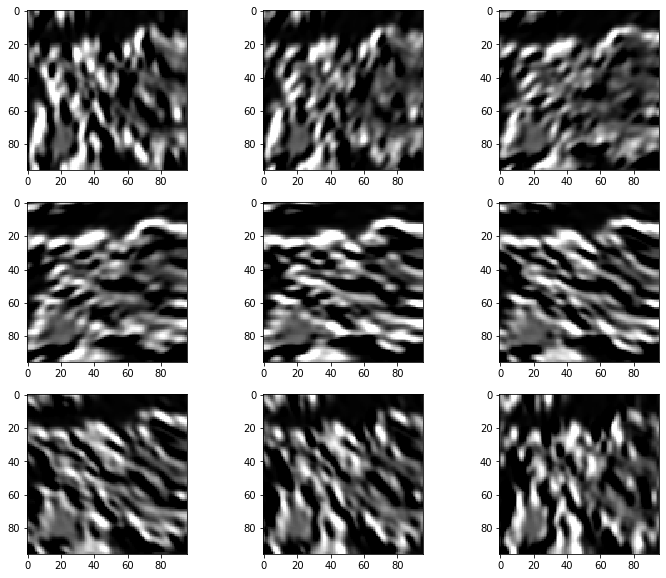

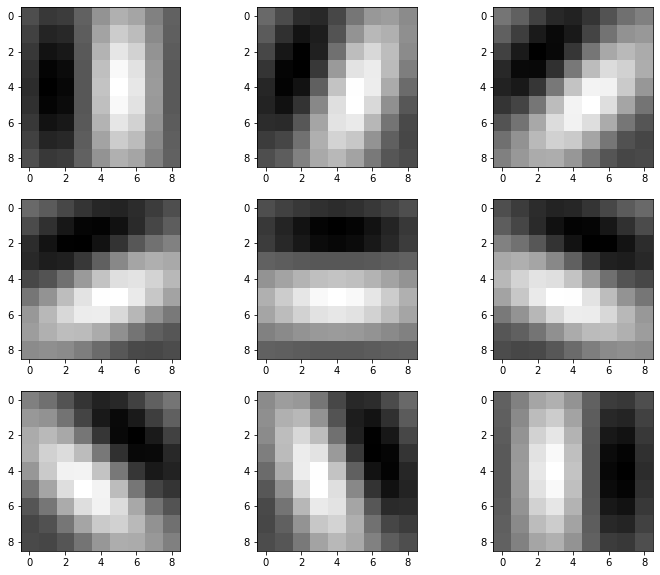

In [21]:
channel = 1

plt.figure(figsize=[12,10])
plt.subplot(331),    plt.imshow(output_img[0,:,:,channel],cmap='gray')  
plt.subplot(332),    plt.imshow(output_img[1,:,:,channel],cmap='gray')  
plt.subplot(333),    plt.imshow(output_img[2,:,:,channel],cmap='gray')  
plt.subplot(334),    plt.imshow(output_img[3,:,:,channel],cmap='gray')  
plt.subplot(335),    plt.imshow(output_img[4,:,:,channel],cmap='gray')  
plt.subplot(336),    plt.imshow(output_img[5,:,:,channel],cmap='gray')  
plt.subplot(337),    plt.imshow(output_img[6,:,:,channel],cmap='gray')  
plt.subplot(338),    plt.imshow(output_img[7,:,:,channel],cmap='gray')  
plt.subplot(339),    plt.imshow(output_img[8,:,:,channel],cmap='gray')  

plt.figure(figsize=[12,10])
plt.subplot(331),    plt.imshow(gabor_filters[0],cmap='gray')  
plt.subplot(332),    plt.imshow(gabor_filters[1],cmap='gray')  
plt.subplot(333),    plt.imshow(gabor_filters[2],cmap='gray')  
plt.subplot(334),    plt.imshow(gabor_filters[3],cmap='gray')  
plt.subplot(335),    plt.imshow(gabor_filters[4],cmap='gray')  
plt.subplot(336),    plt.imshow(gabor_filters[5],cmap='gray')  
plt.subplot(337),    plt.imshow(gabor_filters[6],cmap='gray')  
plt.subplot(338),    plt.imshow(gabor_filters[7],cmap='gray')  
plt.subplot(339),    plt.imshow(gabor_filters[8],cmap='gray')  

## ~~ROF-PDE, K-Means Segmentation~~ [Discontinued]

(<matplotlib.axes._subplots.AxesSubplot at 0x1b63fb406a0>,
 <matplotlib.image.AxesImage at 0x1b63fbb07b8>)

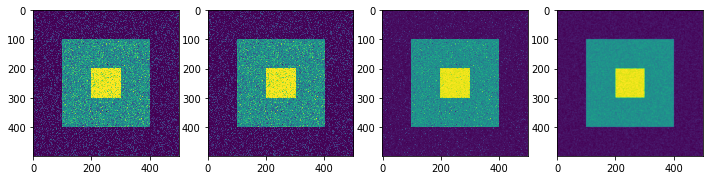

In [31]:
# Synthetic Test
img = np.zeros((500,500))
img[100:400,100:400] = 128
img[200:300,200:300] = 255
 
# Noise Addition
img = img + 30*np.random.standard_normal((500,500))
img = np.clip(img, 0, 255)

plt.figure(figsize=[12,10])
plt.subplot(141),  plt.imshow(img, cmap='viridis')
plt.subplot(142),  plt.imshow(denoise(img, weight=1), cmap='viridis')
plt.subplot(143),  plt.imshow(denoise(img, weight=10), cmap='viridis')
plt.subplot(144),  plt.imshow(denoise(img, weight=100), cmap='viridis')

## ~~Histogram of Oriented Gradients (HOG) Descriptor~~ [Discontinued]

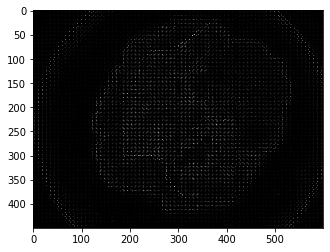

In [186]:
fd, hog_image = hog(clahe_LAB(sample1), orientations=8, pixels_per_cell=(8,8), cells_per_block=(1,1), visualize=True, multichannel=True)
plt.imshow(hog_image, cmap='gray')

## ~~ReliefF Feature Selection~~ [Discontinued]

In [ ]:
X_trainFS    = ReliefF(n_neighbors=500, n_features_to_keep=100).fit_transform(X_train, Y_train)
X_testFS     = ReliefF(n_neighbors=500, n_features_to_keep=100).fit_transform(X_test, Y_test)
print("Feature Vector (Before) : "+str(X_train.shape)+ "\nFeature Vector (After)  : "+str(X_trainFS.shape))

# ● Visualization/Testing Features

In [144]:
target_features = [51,42]

plt.figure(figsize=[20,7])
plt.subplot(121)
plt.title('Discriminating Properties of Target Feature')
plt.scatter(np.linspace(0,14746,num=14747), full_features_M0[:,target_features[0]], c='crimson',  marker='o', alpha=0.8)
plt.scatter(np.linspace(0,14746,num=14747), full_features_B0[:,target_features[0]],  c='navy',     marker='x', alpha=0.8)
plt.ylabel('Feature: Mean')
plt.xlabel('Dermatoscopy Scans')
plt.subplot(122)
plt.title('Discriminating Properties of Target Feature')
plt.scatter(np.linspace(0,14746,num=14747), full_features_M0[:,target_features[1]], c='crimson',  marker='o', alpha=0.8)
plt.scatter(np.linspace(0,14746,num=14747), full_features_B0[:,target_features[1]],  c='navy',     marker='x', alpha=0.8)
plt.ylabel('Feature: Mean')
plt.xlabel('Dermatoscopy Scans')
plt.show()

In [145]:
target_features = [42, 78, 127, 24]

plt.figure(figsize=[20,7])
plt.subplot(121)
plt.title('Discriminating Properties of Target Features')
plt.scatter(full_features_M0[:,target_features[0]], full_features_M0[:,target_features[1]], c='crimson', marker='o', alpha=0.8)
plt.scatter(full_features_B0[:,target_features[0]],   full_features_B0[:,target_features[1]], c='navy',    marker='x', alpha=0.8)
plt.ylabel('GLCM: Homogeneity of H-channel in HSV Color Space')
plt.xlabel('Color Moment: Standard Deviation of L-channel in LUV Color Space')
plt.subplot(122)
plt.title('Discriminating Properties of Target Features')
plt.scatter(full_features_M0[:,target_features[2]], full_features_M0[:,target_features[3]], c='crimson', marker='o', alpha=0.8)
plt.scatter(full_features_B0[:,target_features[2]],   full_features_B0[:,target_features[3]], c='navy',    marker='x', alpha=0.8)
plt.ylabel('Color Moment: Standard Deviation of L-Channel in LAB Color Space')
plt.xlabel('LBP: Bin 5 for H-Channel in HSV Color Space')
plt.show()

In [ ]:
22, 55, 31, 82